In [7]:
from IPython.display import display, clear_output
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from utils import z_normalize_column, synchronize_trials, remove_artifacts_from_column, bandpass, segment_column, decompose_segment, extract_features, top_bot_25, time_diff, train

eeg_data_1 = pd.read_csv('data/subject3/muselsl-session1-1.csv')
gradcpt_data_1 = pd.read_csv('data/subject3/gradcpt-session1-1.csv')
eeg_data_2 = pd.read_csv('data/subject3/muselsl-session1-2.csv')
gradcpt_data_2 = pd.read_csv('data/subject3/gradcpt-session1-2.csv')
eeg_data_3 = pd.read_csv('data/subject3/muselsl-session1-3.csv')
gradcpt_data_3 = pd.read_csv('data/subject3/gradcpt-session1-3.csv')

# Channels
channels = ['AF7', 'AF8', 'TP9', 'TP10'] 

# Add a column to indicate the trial number
eeg_data_1['trial'] = 1
gradcpt_data_1['trial'] = 1
eeg_data_2['trial'] = 2
gradcpt_data_2['trial'] = 2
eeg_data_3['trial'] = 3
gradcpt_data_3['trial'] = 3

In [8]:
# Sync trial start and end times

eeg_data_1, gradcpt_data_1 = synchronize_trials(eeg_data_1, gradcpt_data_1)
eeg_data_2, gradcpt_data_2 = synchronize_trials(eeg_data_2, gradcpt_data_2)
eeg_data_3, gradcpt_data_3 = synchronize_trials(eeg_data_3, gradcpt_data_3)

# Concatenate the trials
eeg_data = pd.concat([eeg_data_1, eeg_data_2, eeg_data_3], ignore_index=True)
gradcpt_data = pd.concat([gradcpt_data_1, gradcpt_data_2, gradcpt_data_3], ignore_index=True)

Gradcpt data had to be truncated


### z-normalization

In [9]:
for channel in channels:
    eeg_data[f'{channel}_normal'] = z_normalize_column(eeg_data[channel])

### Remove artifacts

In [10]:
for channel in channels:
    eeg_data[f'{channel}_artif_removed'] = remove_artifacts_from_column(eeg_data[f'{channel}_normal'])

### Bandpass

In [11]:
for channel in channels:
    eeg_data[f'{channel}_bandpassed'] = bandpass(eeg_data[f'{channel}_artif_removed'])

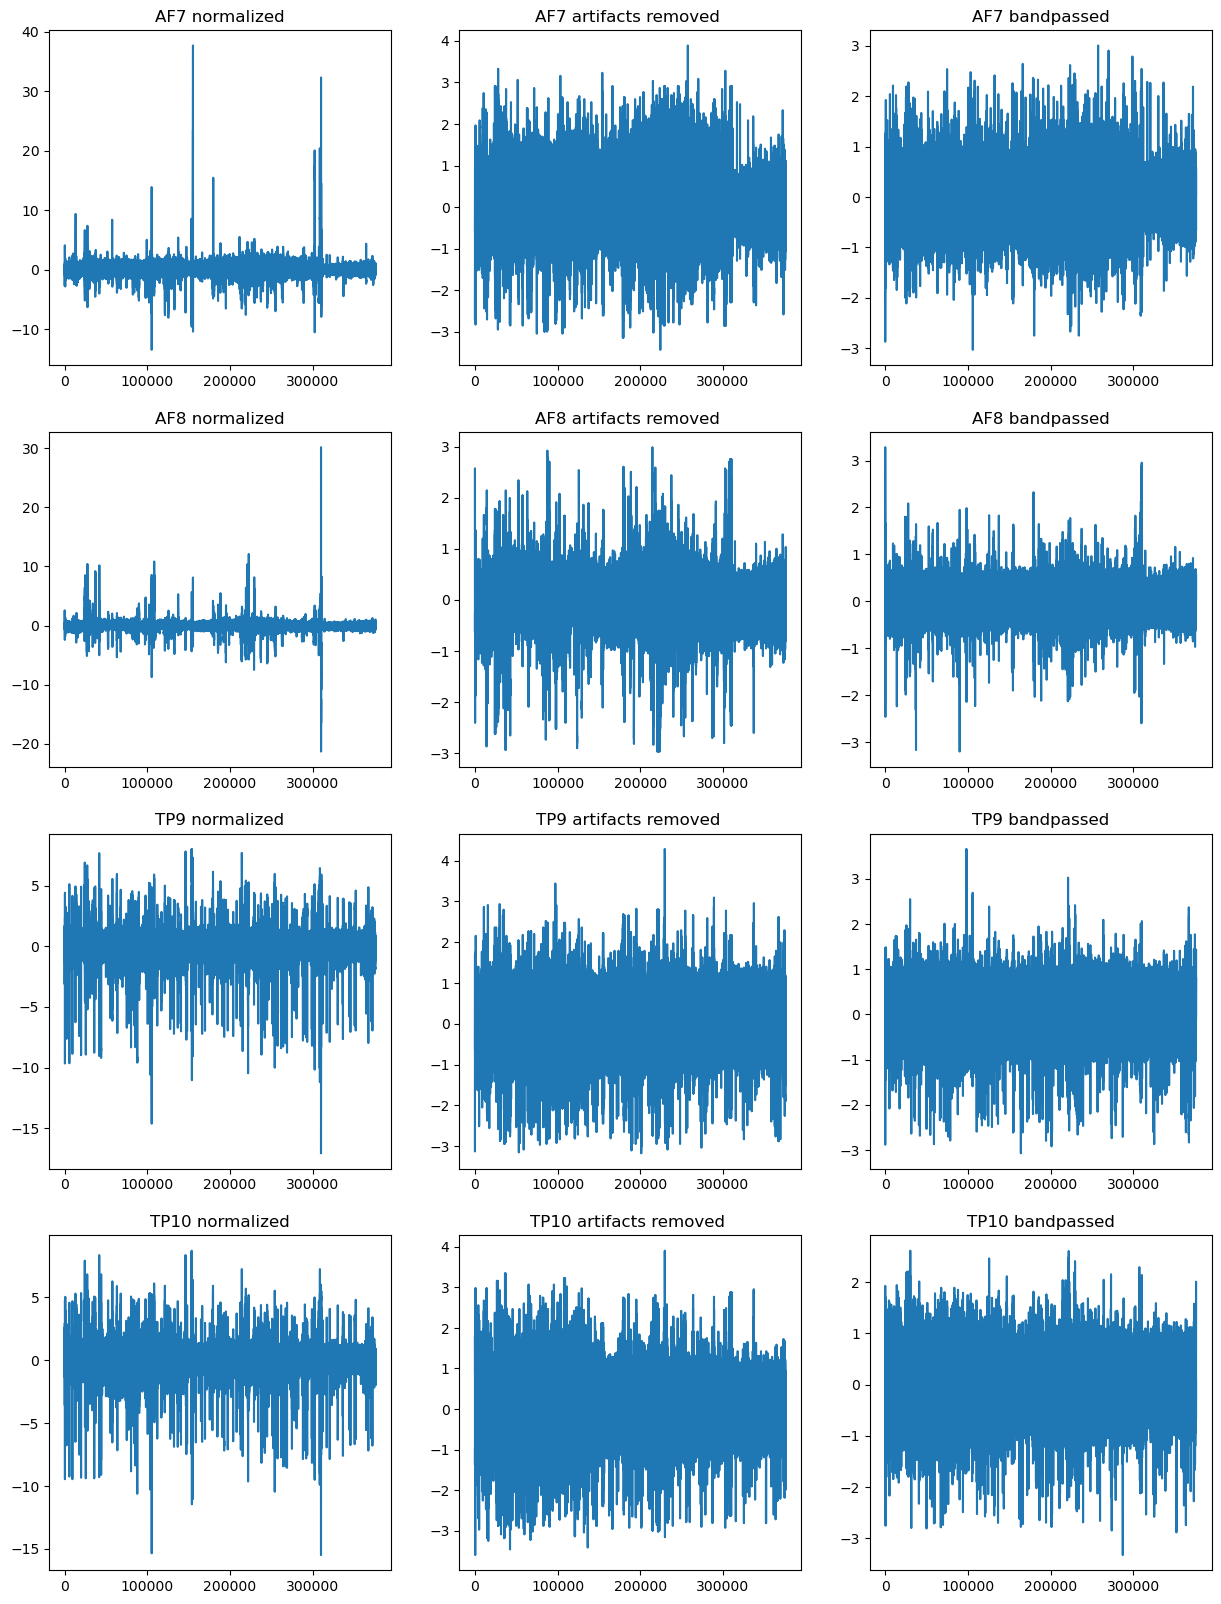

In [12]:
plt.figure(figsize=(15,20))

for i, channel in enumerate(channels):
    plt.subplot(4, 3, i*3+1)
    plt.plot(eeg_data[f'{channel}_normal'], label=f'{channel} normalized')
    plt.title(f'{channel} normalized')

    plt.subplot(4, 3, i*3+2)
    plt.plot(eeg_data[f'{channel}_artif_removed'], label=f'{channel} artifacts removed')
    plt.title(f'{channel} artifacts removed ')

    plt.subplot(4, 3, i*3+3)
    plt.plot(eeg_data[f'{channel}_bandpassed'], label=f'{channel} bandpassed')
    plt.title(f'{channel} bandpassed')

### Separate trials

In [13]:
# Separate preprocessed data back into individual trials
eeg_data_t1 = eeg_data[eeg_data['trial'] == 1].drop(columns=['trial'])
gradcpt_data_t1 = gradcpt_data[gradcpt_data['trial'] == 1].drop(columns=['trial'])

eeg_data_t2 = eeg_data[eeg_data['trial'] == 2].drop(columns=['trial']).reset_index(drop=True)
gradcpt_data_t2 = gradcpt_data[gradcpt_data['trial'] == 2].drop(columns=['trial']).reset_index(drop=True)

eeg_data_t3 = eeg_data[eeg_data['trial'] == 3].drop(columns=['trial']).reset_index(drop=True)
gradcpt_data_t3 = gradcpt_data[gradcpt_data['trial'] == 3].drop(columns=['trial']).reset_index(drop=True)

### Time differences in trials

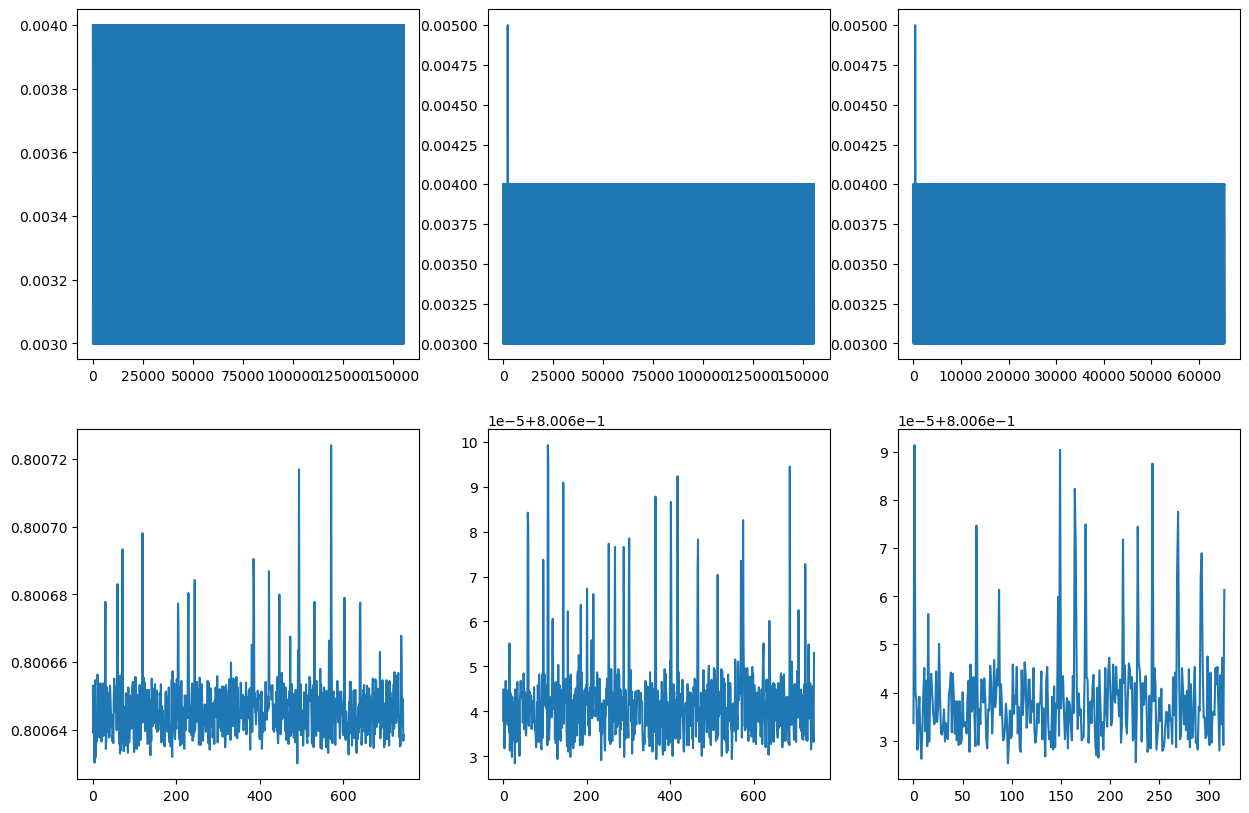

In [14]:
def trial_length(arr):
    diffs = []
    for i in range(1, len(arr)):
        diffs.append(arr[i] - arr[i-1])
    return diffs

plt.figure(figsize=(15,10))

plt.subplot(2, 3, 1)
plt.plot(trial_length(eeg_data_t1['timestamps']))

plt.subplot(2, 3, 2)
plt.plot(trial_length(eeg_data_t2['timestamps']))

plt.subplot(2, 3, 3)
plt.plot(trial_length(eeg_data_t3['timestamps']))

plt.subplot(2, 3, 4)
plt.plot(trial_length(gradcpt_data_t1['start_timestamp']))

plt.subplot(2, 3, 5)
plt.plot(trial_length(gradcpt_data_t2['start_timestamp']))

plt.subplot(2, 3, 6)
plt.plot(trial_length(gradcpt_data_t3['start_timestamp']))


In [15]:
diffs_t1 = time_diff(eeg_data_1, gradcpt_data_1)
diffs_t2 = time_diff(eeg_data_t2, gradcpt_data_t2)
diffs_t3 = time_diff(eeg_data_t3, gradcpt_data_t3)

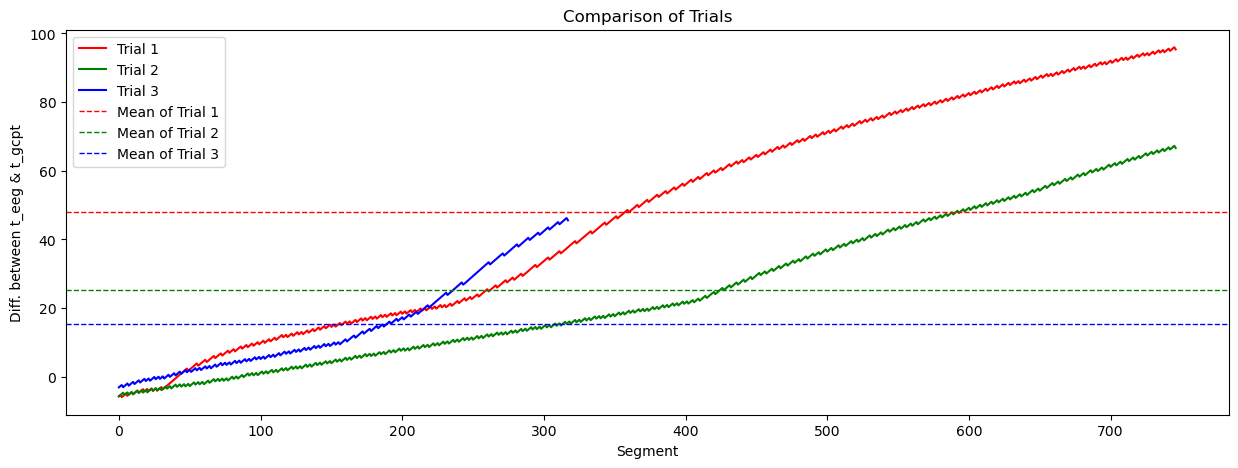

Avg. diff in segment in trial 1: 0.06420087280162416
Avg. diff in segment in trial 2: 0.033794925325782384
Avg. diff in segment in trial 3: 0.04855440904113255


In [16]:
plt.figure(figsize=(15, 5))

plt.plot(diffs_t1, label='Trial 1',  color='r')
plt.plot(diffs_t2, label='Trial 2',  color='g')
plt.plot(diffs_t3, label='Trial 3',  color='b')

# Calculate means
mean_t1 = np.mean(diffs_t1)
mean_t2 = np.mean(diffs_t2)
mean_t3 = np.mean(diffs_t3)

# Plot means
plt.axhline(y=mean_t1, color='r', linestyle='--', label='Mean of Trial 1', linewidth=1)
plt.axhline(y=mean_t2, color='g', linestyle='--', label='Mean of Trial 2', linewidth=1)
plt.axhline(y=mean_t3, color='b', linestyle='--', label='Mean of Trial 3', linewidth=1)

plt.title('Comparison of Trials')
plt.xlabel('Segment')
plt.ylabel('Diff. between t_eeg & t_gcpt')
plt.legend()

plt.show()

print(f'Avg. diff in segment in trial 1: {mean_t1/len(diffs_t1)}')
print(f'Avg. diff in segment in trial 2: {mean_t2/len(diffs_t2)}')
print(f'Avg. diff in segment in trial 3: {mean_t3/len(diffs_t3)}')

### Extract features

In [17]:
# Initialize empty DataFrames for each trial
features_t1 = pd.DataFrame()
features_t2 = pd.DataFrame()
features_t3 = pd.DataFrame()

for trial in [1, 2, 3]:
    # Select the current trial data
    if trial == 1:
        cur_eeg_df = eeg_data_t1
        cur_gcpt_df = gradcpt_data_t1
    elif trial == 2:
        cur_eeg_df = eeg_data_t2
        cur_gcpt_df = gradcpt_data_t2
    else:
        cur_eeg_df = eeg_data_t3
        cur_gcpt_df = gradcpt_data_t3
    
    # Process each channel
    for i, channel in enumerate(channels):
        # Segment the current EEG data
        segments = segment_column(cur_eeg_df[f'{channel}_bandpassed'], cur_gcpt_df)
        # Decompose each segment
        segment_bands = [decompose_segment(segment) for segment in segments]
        # Extract features from the decomposed segments
        features = extract_features(channel, segment_bands)
        
        # Append the features to the respective DataFrame
        if trial == 1:
            features_t1 = pd.concat([features_t1, features], axis=1)
        elif trial == 2:
            features_t2 = pd.concat([features_t2, features], axis=1)
        else:
            features_t3 = pd.concat([features_t3, features], axis=1)
        
        clear_output(wait=True)
        print(f'{(trial-1)*len(channels)+i+1}/{3*len(channels)} Done')

features_t1['in_the_zone'] = gradcpt_data_t1['in_the_zone']
features_t2['in_the_zone'] = gradcpt_data_t2['in_the_zone']
features_t3['in_the_zone'] = gradcpt_data_t3['in_the_zone']

12/12 Done


In [18]:
combined_features_df = pd.concat([features_t1, features_t2, features_t3], ignore_index=True)

## Detach rocket

### Train and eval

In [110]:
from detach_rocket.detach_rocket.detach_classes import DetachMatrix
from sklearn.model_selection import train_test_split

X = combined_features_df.iloc[:, :-1]
y = combined_features_df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

detach_matrix = DetachMatrix(trade_off=0.05)
detach_matrix.fit(X_train, y_train)

# Evaluate Performance on Test Set
detach_test_score, full_test_score= detach_matrix.score(X_test, y_test)
print('Test Accuraccy Full Model: {:.2f}%'.format(100*full_test_score))
print('Test Accuraccy Detach Model: {:.2f}%'.format(100*detach_test_score))

TRAINING RESULTS Full Features:
Optimal Alpha Full Features: 54555.95
Train Accuraccy Full Features: 65.26%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 32.00
Train Accuraccy Detach Model: 75.06%
-------------------------
Test Accuraccy Full Model: 61.40%
Test Accuraccy Detach Model: 55.15%


### Plot SFD Curve and Optimal Model selection

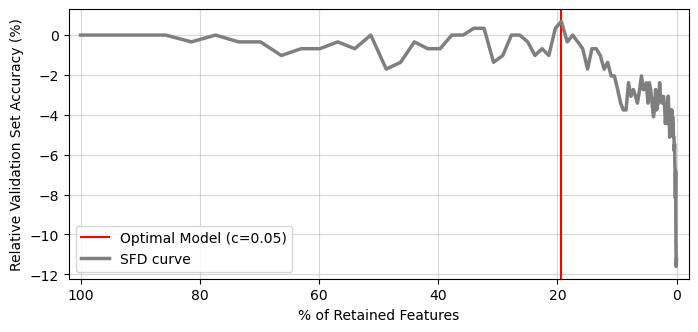

Optimal Model Size: 19.36% of full model


In [111]:
percentage_vector = detach_matrix._percentage_vector
acc_curve = detach_matrix._sfd_curve

c = detach_matrix.trade_off

x=(percentage_vector) * 100
y=(acc_curve/acc_curve[0]-1) * 100

point_x = x[detach_matrix._max_index]
#point_y = y[DetachMatrixModel._max_index]

plt.figure(figsize=(8,3.5))
plt.axvline(x = point_x, color = 'r',label=f'Optimal Model (c={c})')
plt.plot(x, y, label='SFD curve', linewidth=2.5, color='C7', alpha=1)
#plt.scatter(point_x, point_y, s=50, marker='o', label=f'Optimal point (c={c})')

plt.grid(True, linestyle='-', alpha=0.5)
plt.xlim(102,-2)
plt.xlabel('% of Retained Features')
plt.ylabel('Relative Validation Set Accuracy (%)')
plt.legend()
plt.show()

print('Optimal Model Size: {:.2f}% of full model'.format(point_x))

### Keep the optimal features

### TODO: just use X instead of X_train etc.

In [112]:
# Check if '_feature_mask' is available and use it to filter features
if hasattr(detach_matrix, '_feature_mask'):
    feature_mask = detach_matrix._feature_mask
    
    # Use the mask to select features from the training and test sets
    X_train_selected = X_train.loc[:, feature_mask]
    X_test_selected = X_test.loc[:, feature_mask]
else:
    print("Feature mask not found in DetachMatrix object.")

# Add the labels back to the selected feature sets
X_train_selected_with_labels = X_train_selected.assign(Label=y_train)
X_test_selected_with_labels = X_test_selected.assign(Label=y_test)

# Concatenate the training and test sets back into a single DataFrame
selected_features_df = pd.concat([X_train_selected_with_labels, X_test_selected_with_labels], ignore_index=True)

### Train the model

In [113]:
from sklearn.preprocessing import StandardScaler
def train(runs, num_features, df):
    results = []
    
    for _ in range(runs):
        from scipy.stats import ttest_ind
        from sklearn.model_selection import StratifiedKFold, GridSearchCV
        from sklearn.metrics import balanced_accuracy_score
        from sklearn.svm import SVC
        
        features = df.iloc[:, :-1].values
        labels = df.iloc[:, -1].values
        
        def select_top_features(X, y, num_features=num_features):
            # Perform a t-test across features
            t_stats, p_values = ttest_ind(X[y == 0], X[y == 1], axis=0)
            # Select indices of top features based on smallest p-values
            top_features_indices = np.argsort(np.abs(t_stats))[-num_features:]
            return top_features_indices
        
        outer_cv = StratifiedKFold(n_splits=10, shuffle=True)
        
        balanced_acc_scores = []
        
        for train_index, test_index in outer_cv.split(features, labels):
            X_train, X_test = features[train_index], features[test_index]
            y_train, y_test = labels[train_index], labels[test_index]
        
            # Feature selection for the outer fold
            top_features_indices = select_top_features(X_train, y_train)
            X_train_selected = X_train[:, top_features_indices]
            X_test_selected = X_test[:, top_features_indices]
            
            # Initialize the scaler
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train_selected)
            X_test_scaled = scaler.transform(X_test_selected)
        
            # Inner CV for hyperparameter tuning
            inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
            param_grid = {'C': [0.1, 0.5, 1], 'gamma': ['scale'], 'kernel': ['rbf']}
            grid_search = GridSearchCV(SVC(), param_grid, cv=inner_cv, scoring='balanced_accuracy')
            grid_search.fit(X_train_scaled, y_train)
        
            best_model = grid_search.best_estimator_
            
            balanced_acc = balanced_accuracy_score(y_test, best_model.predict(X_test_scaled))
            balanced_acc_scores.append(balanced_acc)
        
        final_performance = np.mean(balanced_acc_scores)
        results.append(round(final_performance, 3))
    
    print(f'Avg: {round((sum(results) / len(results)) * 100, 3)}%')

In [114]:
n_features = len(selected_features_df.columns)-1 # last col is the label
for feats in [5, 15, 20, 25, n_features]:
    print(f'---{feats} FEATURES---')
    print('Combined:')
    train(runs=5, num_features=feats, df=selected_features_df)

---5 FEATURES---
Combined:
Avg: 57.02%
---15 FEATURES---
Combined:
Avg: 56.48%
---20 FEATURES---
Combined:
Avg: 56.9%
---25 FEATURES---
Combined:
Avg: 57.04%
---448 FEATURES---
Combined:
Avg: 62.14%


### See feature importance

In [117]:
from scipy.stats import entropy, skew, ttest_ind
def top_bot_25(feature_df):
        t_values = []
        feature_names = []

        # Perform t-test for each feature against 'in_the_zone'
        for column in feature_df.columns[:-1]:  # Exclude the last column ('in_the_zone')
            t_stat, p_val = ttest_ind(feature_df[column], feature_df['Label'], nan_policy='omit')
            t_values.append(t_stat)
            feature_names.append(column)

        # Create a DataFrame to store features and their corresponding t-values
        t_values_df = pd.DataFrame({'Feature': feature_names, 'T-value': t_values})

        # Sort the DataFrame by the absolute t-values
        t_values_df['Abs T-value'] = t_values_df['T-value'].abs()
        t_values_df_sorted = t_values_df.sort_values(by='Abs T-value', ascending=False)

        # Select the 25 most important features
        top_25_features = t_values_df_sorted.head(25)

        # Select the 25 least important features
        bottom_25_features = t_values_df_sorted.tail(25)

        # You can now print or further analyze these subsets
        print("Top 25 Most Important Features:")
        print(top_25_features)

        print("\nBottom 25 Least Important Features:")
        print(bottom_25_features)

In [118]:
top_bot_25(selected_features_df)

Top 25 Most Important Features:
                             Feature     T-value  Abs T-value
8                 AF7_alpha_sef_win0  941.240470   941.240470
151               AF8_alpha_sef_win0  865.910633   865.910633
284               TP9_alpha_sef_win0  633.127838   633.127838
153                AF8_beta_sef_win0  442.061442   442.061442
175               AF8_beta_sef_win-1  405.819207   405.819207
297               TP9_beta_sef_win-1  390.784036   390.784036
387             TP10_delta_sef_win-1  329.988622   329.988622
399             TP10_delta_sef_win-3  300.276108   300.276108
293  TP9_delta_total_variation_win-1  293.728935   293.728935
306  TP9_theta_total_variation_win-2  284.245871   284.245871
301  TP9_delta_total_variation_win-2  281.276138   281.276138
291               TP9_gamma_sef_win0  280.335086   280.335086
312  TP9_theta_total_variation_win-3  273.572050   273.572050
400             TP10_theta_sef_win-3  265.438322   265.438322
414             TP10_delta_sef_win-7  

In [120]:
def select_top_features(X, y, num_features=25):
            # Perform a t-test across features
            t_stats, p_values = ttest_ind(X[y == 0], X[y == 1], axis=0)
            # Select indices of top features based on smallest p-values
            top_features_indices = np.argsort(np.abs(t_stats))[-num_features:]
            return top_features_indices

In [126]:
features = selected_features_df.iloc[:, :-1].values
labels = selected_features_df.iloc[:, -1].values

top_features_indices = select_top_features(features, labels)

# Get the column names for these indices
top_features_names = selected_features_df.columns[top_features_indices]

# Print the names of the top features
print(top_features_names)

Index(['AF8_delta_standard_deviation_win0', 'AF7_delta_total_variation_win0',
       'AF7_delta_total_variation_win-9', 'AF8_delta_hjorth_activity_win-2',
       'AF8_delta_energy_win-2', 'AF8_theta_total_variation_win-1',
       'AF7_delta_energy_win-9', 'AF7_delta_hjorth_activity_win-9',
       'AF8_delta_total_variation_win-4', 'AF8_delta_standard_deviation_win-5',
       'AF8_delta_hjorth_activity_win-7', 'AF8_delta_energy_win-7',
       'AF8_delta_total_variation_win-8', 'AF8_theta_total_variation_win-9',
       'AF8_delta_total_variation_win-1', 'AF8_theta_total_variation_win-8',
       'AF8_delta_standard_deviation_win-2',
       'AF8_delta_standard_deviation_win-1', 'AF8_delta_total_variation_win-2',
       'AF8_delta_standard_deviation_win-9', 'AF8_delta_hjorth_activity_win-9',
       'AF8_delta_energy_win-9', 'AF8_delta_hjorth_activity_win-8',
       'AF8_delta_energy_win-8', 'AF8_delta_standard_deviation_win-8'],
      dtype='object')
